In [1]:
import numpy as np
import cv2 as cv
import  matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
img1 = cv.imread('morpheus_L_rectified.png')
img2 = cv.imread('morpheus_R_rectified.png')

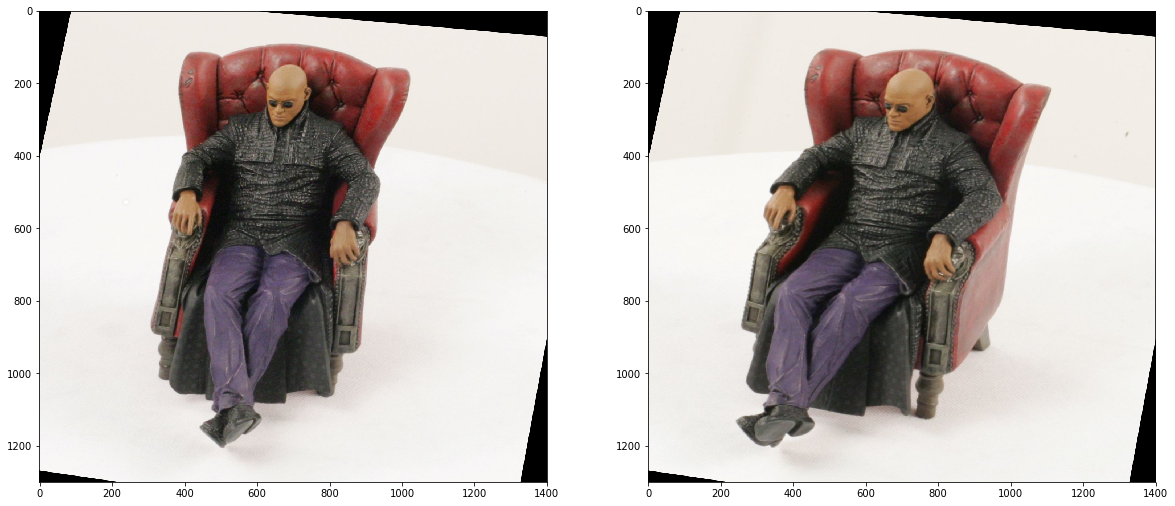

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(121),plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.subplot(122),plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()

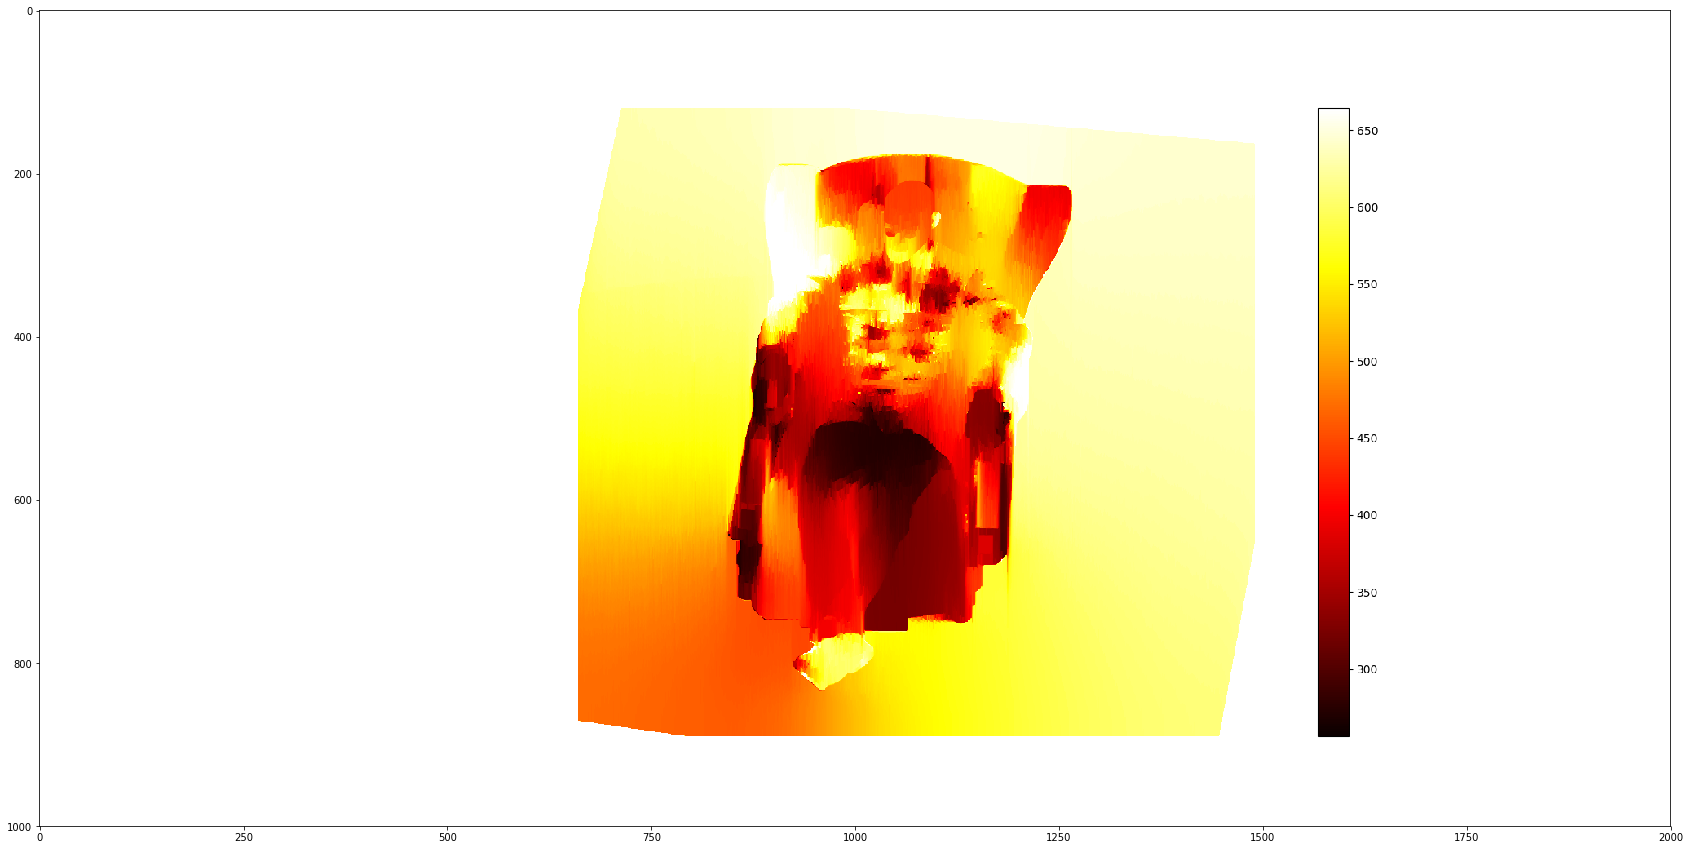

In [4]:
fig, ax = plt.subplots(figsize=(30, 15))

# fig.axes[0].get_xaxis().set_visible(False)
# fig.axes[0].get_yaxis().set_visible(False)
# plt.axis('off')
img_depth = cv.imread('data/FurukawaPonce/profundidade.png')

plt.imshow(cv.cvtColor(img_depth, cv.COLOR_BGR2RGB));

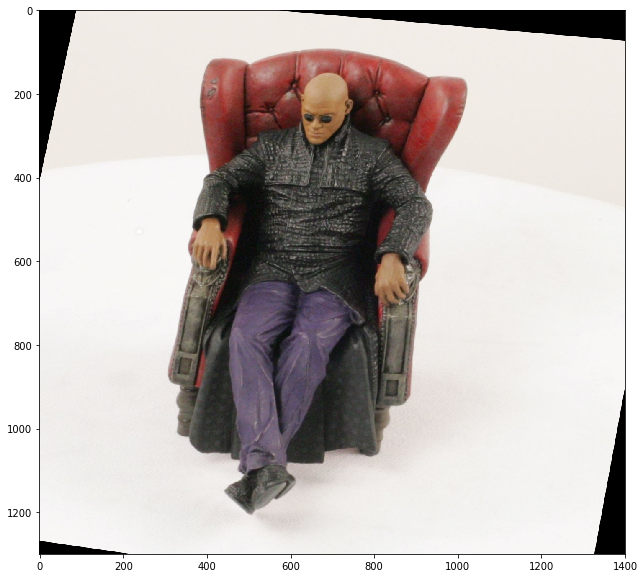

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))


plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB));



### Fórmula de triangulação

distancia = altura * distancia focal / altura em pixels na imagem

altura = distancia * altura em pixels na imagem / distancia focal

In [6]:
f = 6704.926882 #pixels

In [50]:
top_couch_distance = 250 # mm
#low_couch_distance = ??? # mm

top_couch_point =  np.array([160,1015])
bottom_couch_point = np.array([600,850])
euclidean_dist = np.linalg.norm(top_couch_point - bottom_couch_point)
print(f'height of the couch in pixels: {euclidean_dist}px')
#euclidean_dist = 400

height of the couch in pixels: 469.9202059924642px


In [51]:
height = top_couch_distance * euclidean_dist / f
print(f'morpheus couch height: {round(height,2)}cm')

morpheus couch height: 17.52cm


## Using matched points

In [9]:
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
len(pts1),len(pts2)

(268, 268)

In [10]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

In [11]:
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

In [12]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
len(pts1),len(pts2)

(202, 202)

## Load projection matrices

In [13]:
mtx_1 = [ 
    [4265.08, 5195.24, -565.379, -1.37072e+06],
    [1636.7, -1954.5, -6218.58, 2.75156e+06],
    [-0.645659, 0.624306, -0.439734, 2977.41] ]
mtx_2 = [
    [2567.28, 6197.89, -641.912, -1.26828e+06],
    [1969.58, -1410.57, -6237.08, 2.45107e+06],
    [-0.803929, 0.431864, -0.40889, 3242.75] ]

mtx_1 = np.array(mtx_1)
mtx_2 = np.array(mtx_2)

In [14]:
pts1.shape

(202, 2)

## Triangulate 2d points to get the 3d

In [15]:
# Breaks
points_3D = cv.triangulatePoints(mtx_1, mtx_2, pts1[:10].T, pts2[:10].T)
print(points_3D.shape)
points_3D

(4, 10)


array([[1991362351, 1070921442, 1991362351, 1070921442, 1991362351,
        1070921442, 1991362351, 1070921442, 1991362351, 1070921442],
       [1991362351, 1070921442, 1991362351, 1070921442, 1991362351,
        1070921442, 1991362351, 1070921442, 1991362351, 1070921442],
       [-684625945, 1071143391, -684625945, 1071143391, -684625945,
        1071143391, -684625945, 1071143391, -684625945, 1071143391],
       [ 143961425, 1072409769,  143961425, 1072409769,  143961425,
        1072409769,  143961425, 1072409769,  143961425, 1072409769]],
      dtype=int32)

In [16]:
 pts1[:10].T

array([[333, 337, 359, 361, 370, 372, 378, 382, 388, 391],
       [873, 817, 728, 835, 737, 817, 799, 577, 647, 208]], dtype=int32)

In [17]:
pts1[:10]

array([[333, 873],
       [337, 817],
       [359, 728],
       [361, 835],
       [370, 737],
       [372, 817],
       [378, 799],
       [382, 577],
       [388, 647],
       [391, 208]], dtype=int32)

### left points

In [18]:
# left line of blue square
pts_chair_left = np.array([[410,120],
                          [1015,160]])
pts_chair_left

array([[ 410,  120],
       [1015,  160]])

### right points

In [19]:
# left line of blue square
pts_chair_right = np.array([[465,120],
                            [325,700]])
pts_chair_right

array([[465, 120],
       [325, 700]])

In [20]:
points_3D = cv.triangulatePoints(mtx_1, mtx_2, pts_chair_left, pts_chair_right)
print(points_3D.shape)
points_3D

(4, 2)


array([[1991362351, 1070921442],
       [1991362351, 1070921442],
       [-684625945, 1071143391],
       [ 143961425, 1072409769]], dtype=int32)

In [44]:
point_3D_TOP = points_3D.T[0]
point_3D_BOT = points_3D.T[1]

point_3D_TOP

array([1991362351, 1991362351, -684625945,  143961425], dtype=int32)

In [45]:
point_3D_TOP = point_3D_TOP / point_3D_TOP[3]
point_3D_TOP

array([13.83261072, 13.83261072, -4.75562079,  1.        ])

In [46]:
point_3D_BOT = point_3D_BOT / point_3D_BOT[3]
point_3D_BOT

array([0.99861217, 0.99861217, 0.99881913, 1.        ])

In [47]:
euclidean_dist_3d = np.linalg.norm(point_3D_TOP - point_3D_BOT)
euclidean_dist_3d

19.04039433945607

### calibrate stereo setup (FAIL)

In [22]:
def load_calib_dict(file_path):
    """ """
    d = {}
    data = ''
    with open(file_path) as f:
        data = f.readlines()
        for idx in range(len(data)):
            data[idx] = data[idx].replace("\n","")
            
        d['fc'] = eval(data[1].split('=')[1].replace(";",","))
        d['cc'] = eval(data[4].split('=')[1].replace(";",","))
        d['alpha_c'] = float(data[6].split('=')[1].replace(";",""))
        
        r0 = eval(data[11].split("=")[1].replace(";","]"))
        r1 = eval(data[12].replace("      ","[").replace(";","]"))
        r2 = eval(data[13].replace("     ","["))
        d['R'] = np.array([r0, r1, r2])
        
        d['Tc'] = eval(data[15].split("=")[1].replace(";",','))
    return d

calib_dict_left = load_calib_dict("data/FurukawaPonce/MorpheusL.txt")
calib_dict_right = load_calib_dict("data/FurukawaPonce/MorpheusR.txt")

calib_dict_left

{'fc': [6704.926882, 6705.241311],
 'cc': [738.251932, 457.560286],
 'alpha_c': 0.000103,
 'R': array([[ 0.70717199,  0.70613396, -0.03581348],
        [ 0.28815232, -0.33409066, -0.89741388],
        [-0.64565936,  0.62430623, -0.43973369]]),
 'Tc': [-532.2859, 207.1836, 2977.408]}

In [23]:
## Builds K matrix 

K_left = [[calib_dict_left['fc'][0],0,calib_dict_left['cc'][0]],
         [0, calib_dict_left['fc'][1], calib_dict_left['cc'][1]],
         [0, 0, 1]]
K_left = np.array(K_left)

K_right = [[calib_dict_right['fc'][0],0,calib_dict_right['cc'][0]],
         [0, calib_dict_right['fc'][1], calib_dict_right['cc'][1]],
         [0, 0, 1]]
K_right = np.array(K_right)


dist_left = np.array([-0.125368, -0.097388, -0.003711, -0.000161, 0.000000])
dist_right = np.array([-0.106090, -0.533543, -0.005174, 0.000517, 0.000000])

In [24]:
# cv.stereoCalibrate(objp[:4],pts1[:4],pts2[:4], K_left, dist_left,K_right,dist_right,img1.shape[:2])

## FAIL

## Using homography

In [25]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    corner = (400,160)
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)# blue
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)# green
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)# red
    return img

# def draw(img, corners, imgpts):
#     imgpts = np.int32(imgpts).reshape(-1,2)
#     # draw ground floor in green
#     img = cv.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
#     # draw pillars in blue color
#     for i,j in zip(range(4),range(4,8)):
#         img = cv.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
#     # draw top layer in red color
#     img = cv.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
#     return img

In [26]:
H, mask = cv.findHomography(pts1, pts2)

In [27]:
num, r_vecs, t_vecs, Ns = cv.decomposeHomographyMat(H, K_left)

In [28]:
r_vecs[0]

array([[ 0.92622086, -0.15791691,  0.34231152],
       [ 0.06626719,  0.96209669,  0.26453471],
       [-0.37111129, -0.22233355,  0.90157873]])

In [29]:
t_vecs[0]

array([[ 0.34634172],
       [ 0.26538938],
       [-0.02414965]])

In [30]:
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
# axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
#                    [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])

In [31]:
imgpts, jac = cv.projectPoints(axis, r_vecs[0], t_vecs[0], K_left, dist_left)

In [32]:
img = draw(img1,pts1,imgpts)

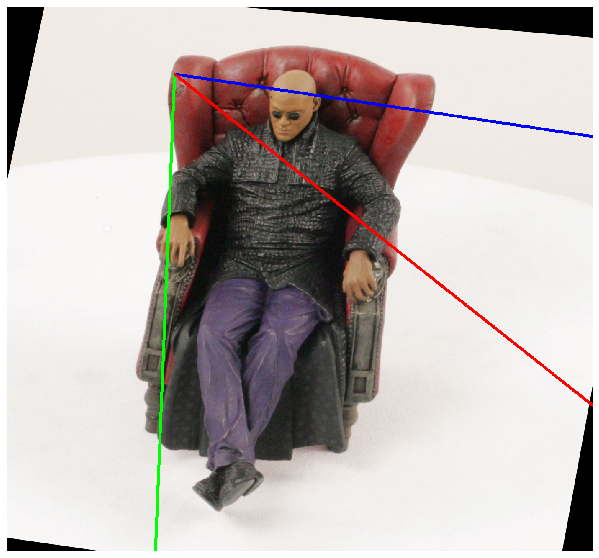

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))

fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)


plt.axis('off')

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

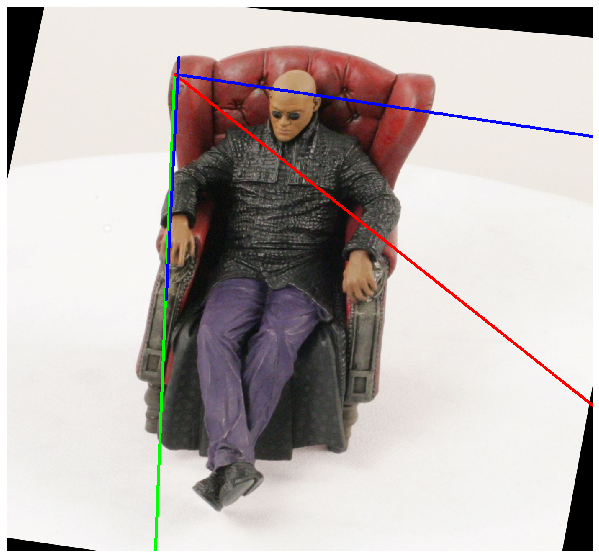

In [34]:
#horizontal_blue
#img_tst = cv.line(img1, (410,120), (1015,160), (255,0,0), 5)
#img_tst = cv.line(img1, (380,700), (965,760), (255,0,0), 5) #(985,760), (255,0,0), 5)

#vertical_blue
img_tst = cv.line(img1, (410,120), (380,700), (255,0,0), 5)
#img_tst = cv.line(img1, (1015,160), (965,760), (255,0,0), 5)

fig, ax = plt.subplots(figsize=(20, 10))

fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)


plt.axis('off')

plt.imshow(cv.cvtColor(img_tst, cv.COLOR_BGR2RGB))
plt.show()

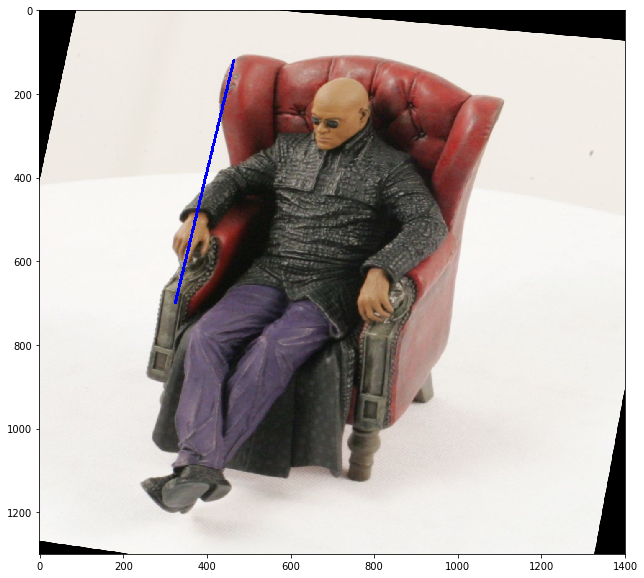

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))


plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB));

# #horizontal_blue
# img_tst = cv.line(img1, (410,120), (1015,160), (255,0,0), 5)
# img_tst = cv.line(img1, (380,700), (965,760), (255,0,0), 5) #(985,760), (255,0,0), 5)

# #vertical_blue
img2 = cv.line(img2, (465,120), (325,700), (255,0,0), 5)
# img_tst = cv.line(img1, (1015,160), (965,760), (255,0,0), 5)

# fig, ax = plt.subplots(figsize=(20, 10))

# fig.axes[0].get_xaxis().set_visible(False)
# fig.axes[0].get_yaxis().set_visible(False)


# plt.axis('off')

plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()